# Gaussian Process for Machine Learning, Chapter 2

## Exercice 1a: Computation of priors

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)


def k(xp, xq , l):
    """Covariance functions with squared exponential of length-scale l."""
    return np.exp(-0.5 * (xp - xq)**2 / float(l))


def K(x1, x2, l=1.0):
    """Compute the covariance matrix from the observations x."""
    cov_matrix = np.zeros((len(x1), len(x2)))
    for i, p in enumerate(x1):
        for j, q in enumerate(x2):
            cov_matrix[i, j] = k(p, q, l)
    return cov_matrix


def generate_samples(mean, cov):
    """
    Generate samples for multivariate gaussian.
    
    :param m    Mean vector
    :param K    Covariance matrix
    :returns    Vector of size of m with random gaussian samples
    """
    if len(mean) != cov.shape[0]:
        raise Exception("Dimensions don't agree between mean and covariance matrix.")
    N = len(mean)
    u = np.random.normal(size=N)  # Generate N normal scalars
    L = np.linalg.cholesky(cov)   # Compute the Cholesky decomposition
    x = mean + np.dot(L,u)        # Genereate the samples
    return x


N = 50                     # Number of observations (size of training set)
epsilon = 0.0001           # Small constant
x = np.linspace(-5, 5, N)  # Index of observations (training set)
cov = K(x, x) + epsilon * np.identity(N)  # Covariance of the data (additive term for numerical reasons)
mean = np.zeros(N)         # Mean of the data

In [3]:
# Observed values
#y = np.random.multivariate_normal(mean, cov)
y = generate_samples(mean, cov)
# Interpolated observed values
f1 = generate_samples(mean, cov)
f2 = generate_samples(mean, cov)
# Simulates the whole function space
# X = []
# for i in range(5000):
#     X.append(generate_samples(mean, cov))
# Verifies than mean and variance of function space are 0 and 1
# M = np.mean(X, axis=0)
# S = np.std(X, axis=0)

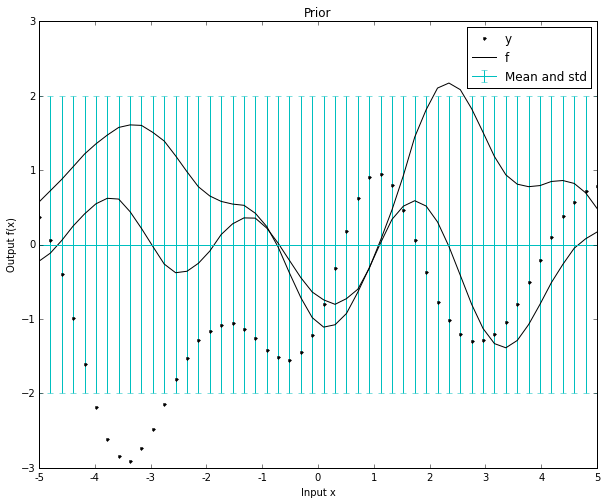

In [7]:
# Plot
plt.figure()
plt.figure(figsize=(10,8))
ax1, = plt.plot(x, y, 'k.')
ax2, = plt.plot(x, f1, 'k-')
plt.plot(x, f2, 'k-')
ax3 = plt.errorbar(x, mean, 2 * np.sqrt(np.diag(cov)), color="c")
plt.xlim([-5, 5])
plt.xticks(range(-5, 6), range(-5, 6))
plt.legend((ax1, ax2, ax3), ("y", "f", "Mean and std"), numpoints=1)
plt.title("Prior")
plt.xlabel("Input x")
plt.ylabel("Output f(x)")
plt.show()
plt.close()

## Exerice 1b: Computation of posteriors

In [53]:
N = 50
x_test = np.linspace(-5, 5, N)
x = [-4, -2.5, -1, 0, 2.5]
y = [-2, 0, 1, 2, -1]

m = np.dot(np.dot(K(x_test, x), np.linalg.inv(K(x, x))), y)
S = K(x_test, x_test) - np.dot(np.dot(K(x_test, x), np.linalg.inv(K(x, x))), K(x, x_test))
S = S + epsilon * np.identity(len(m))

In [54]:
# Generate series
f1 = generate_samples(m, S)
f2 = generate_samples(m, S)
f3 = generate_samples(m, S)
s = [2 * np.sqrt(S[i,i]) for i in range(len(x_test))]

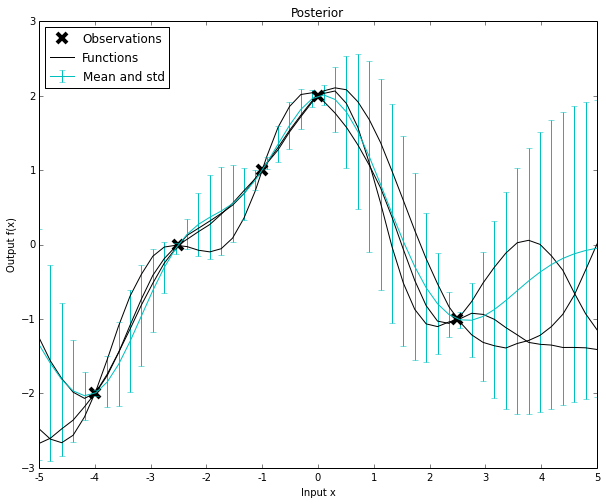

In [55]:
# Plot
import math
plt.figure()
plt.figure(figsize=(10,8))
ax1, = plt.plot(x, y, 'kx', mew=4, ms=10)
ax2, = plt.plot(x_test, f1, 'k')
plt.plot(x_test, f2, 'k')
plt.plot(x_test, f3, 'k')
ax3 = plt.errorbar(x_test, m, s, color="c", alpha=1.0)
plt.xlim([-5, 5])
plt.xticks(range(-5, 6), range(-5, 6))
plt.legend((ax1, ax2, ax3), ("Observations", "Functions", "Mean and std"), numpoints=1, loc=2)
plt.title("Posterior")
plt.xlabel("Input x")
plt.ylabel("Output f(x)")
plt.show()

## Implementation: GPR Algorithm

In [56]:
%matplotlib inline
from numpy.linalg import inv, cholesky
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)


def k(xp, xq , l, sigma_f):
    """Covariance functions with squared exponential of length-scale l and signal noise sigma_f."""
    return sigma_f * np.exp(-0.5 * (xp - xq)**2 / float(l**2))


def K(x1, x2, l=1.0, sigma_f=1.0):
    """Compute the covariance matrix from the observations x."""
    cov_matrix = np.zeros((len(x1), len(x2)))
    for i, p in enumerate(x1):
        for j, q in enumerate(x2):
            cov_matrix[i, j] = k(p, q, l, sigma_f)
    return cov_matrix


def gaussian_process_regression(x, y, x_test, k, l=1.0, sigma_n=0.0, sigma_f=1.0):
    """
    Computes a regression using Gaussian Process using observations x and y = f(x) and a covariance function k.
    
    :param x        Indices of observations
    :param y        Values at indices x (= f(x))
    :param x_test   Indices to get predicted values
    :param k        Covariance function
    :param sigma_n  Observations noise
    :return:        Mean m, variance var and log marginal likelihood lml
    """
    n = len(x)
    n_test = len(x_test)
    L = cholesky(K(x, x, l, sigma_f) + sigma_n * np.eye(n))
    L_inv = inv(L)
    a = np.dot(inv(np.transpose(L)), np.dot(L_inv, y))
    m = np.dot(K(x_test, x, l, sigma_f), a)  # Predictive mean
    v = np.dot(L_inv, K(x, x_test, l, sigma_f))
    var = K(x_test, x_test, l, sigma_f) - np.dot(np.transpose(v), v)  # Predictive variance
    lml = -0.5 * np.dot(np.transpose(y), a) - np.sum(np.diag(L)) - n * 0.3990899342  # Log maginal likelihood (last term is log2π / 2)
    return m, var + sigma_n * np.eye(n_test), lml

### Crude Oil Price

Log marginal likelihood: -65325.5198445


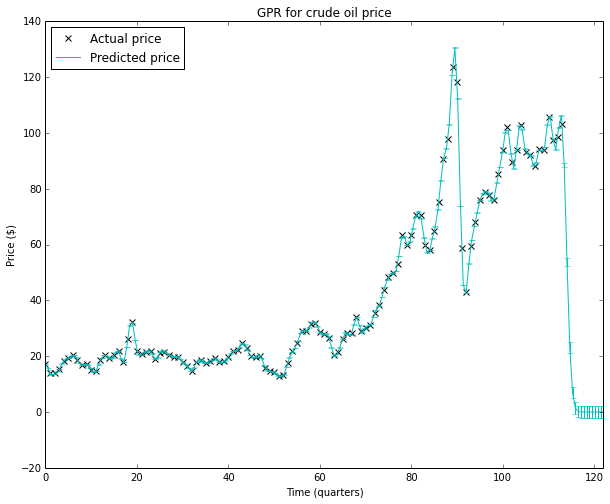

In [49]:
# Load data
crude_oil = []
with open("DCOILWTICO.txt") as f:
    data = f.readlines()
for entry in data:
    date, price = entry.split()
    price = price.replace('\r', '')
    price = price.replace('\n', '')
    price = float(price)
    crude_oil.append((date, price))

# Preprocessing
length = 114
crude_oil = crude_oil[:length]
prices = [price for _, price in crude_oil]
#prices = prices - np.mean(prices)
#prices = prices / np.std(prices)

# Paramters
next_quarters = 8
length_scale = 1.0
observations_noise = 0.0
signal_noise = 1.0

# Regression
x = range(len(prices))
y = prices
x_test = np.linspace(0, len(x) + next_quarters, 200)

m, var, lml = gaussian_process_regression(x, y, x_test, k, 
                                          l=length_scale, 
                                          sigma_n=observations_noise, 
                                          sigma_f=signal_noise)
print "Log marginal likelihood:", lml

# Plot
plt.figure(figsize=(10,8))
plt.plot(x, y, 'kx', mew=1)
plt.errorbar(x_test, m, 2 * np.sqrt(np.diag(var)), color="c")
plt.xlim((0, len(x) + next_quarters))
plt.title("GPR for crude oil price")
plt.xlabel("Time (quarters)")
plt.ylabel("Price ($)")
plt.legend(("Actual price", "Predicted price"), loc=2, numpoints=1)
plt.show()

#### Remark
The problem in this case is that the data don't have a smooth shape. It is "bi-linear", since it has two regimes: one from 0 to 70 and one from 70 to 115. On top of that, there is a sort of periodic signal. In order to improve the fitting, one should consider other kernels than the squared exponential, for instance, a combination of linear and periodic. Considering a mean function (instead of 0) might also be a good idea.

### Swiss Gross Domestic Product

Log marginal likelihood: -24743906409.5


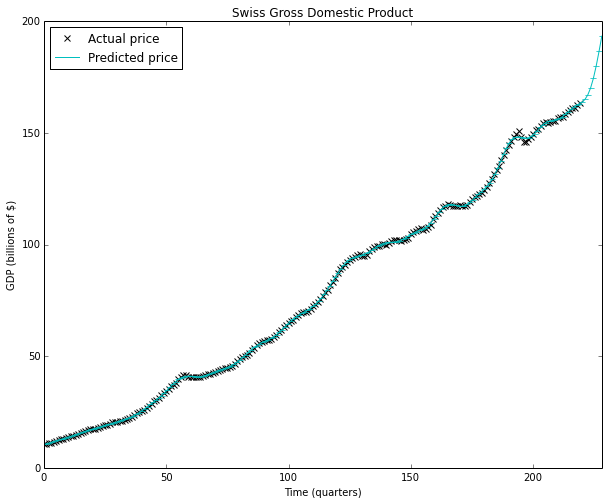

In [48]:
# Load data
swiss_gdp = []
with open("swiss-gdp.txt") as f:
    data = f.readlines()
for entry in data:
    swiss_gdp.append(float(entry.replace('\r\n', '')))

# Parameters
next_quarters = 8
length_scale = 10.0
observations_noise = 0.000000001
signal_noise = 0.0001

# Regression
x = range(len(swiss_gdp))
y = swiss_gdp
x_test = np.linspace(0, len(x) + next_quarters, 200)

m, var, lml = gaussian_process_regression(x, y, x_test, k, 
                                          l=length_scale, 
                                          sigma_n=observations_noise, 
                                          sigma_f=signal_noise)
print "Log marginal likelihood:", lml

# Plot
plt.figure(figsize=(10,8))
plt.plot(x, y, 'kx', mew=1)
plt.errorbar(x_test, m, 2 * np.sqrt(np.diag(var)), color="c")
plt.xlim((0, len(x) + next_quarters))
plt.title("Swiss Gross Domestic Product")
plt.xlabel("Time (quarters)")
plt.ylabel("GDP (billions of $)")
plt.legend(("Actual price", "Predicted price"), loc=2, numpoints=1)
plt.show()

#### Remark
We found manually some parameters that kind of fit the data. However, if we increase the prediction period `next_quarters`, we see that the regression drops to zero in the end. Again, the choice of squared exponential kernel might not be the most suitable choice.